In [115]:
import os
import numpy as np
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline

In [116]:
files = [os.path.join('img_align_celeba', file_i)
 for file_i in os.listdir('img_align_celeba')
 if '.jpg' in file_i]

In [117]:
y=np.array([1,1,0,1,1,1,0,0,1,1,1,0,0,1,0,0,1,1,1,0,0,1,0,1,0,1,1,1,1,0,1,0,0,1,1,0,0,0,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,1,1,0,1,1,0,0,0,0,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1])
y=y.reshape(1,y.shape[0])
classes=np.array(['Male', 'Female'])
y_train=y[:,:80]
y_test=y[:,80:]

In [118]:
def imcrop_tosquare(img):
    if img.shape[0] > img.shape[1]:
        extra = (img.shape[0] - img.shape[1]) // 2
        crop = img[extra:-extra, :]
    elif img.shape[1] > img.shape[0]:
        extra = (img.shape[1] - img.shape[0]) // 2
        crop = img[:, extra:-extra]
    else:
        crop = img
    return crop

In [119]:
imgs = []
for file_i in files:
    img = plt.imread(file_i)
    square = imcrop_tosquare(img)
    rsz = imresize(square, (64, 64))
    imgs.append(rsz)
print(len(imgs))

100


In [120]:
data = np.array(imgs)
data=data/255
data.shape

(100, 64, 64, 3)

In [121]:
train_x_orig=data[:80,:,:,:]
test_x_orig=data[80:,:,:,:]

In [122]:

m_train = train_x_orig.shape[0]
m_test = y_test.shape[1]
num_px = train_x_orig.shape[1]


print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x shape: " + str(train_x_orig.shape))
print ("y_train shape: " + str(y_train.shape))
print ("test_x shape: " + str(test_x_orig.shape))
print ("y_test shape: " + str(y_test.shape))

Number of training examples: m_train = 80
Number of testing examples: m_test = 20
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_x shape: (80, 64, 64, 3)
y_train shape: (1, 80)
test_x shape: (20, 64, 64, 3)
y_test shape: (1, 20)


In [123]:
train_x = train_x_orig.reshape(train_x_orig.shape[0],-1).T
test_x = test_x_orig.reshape(test_x_orig.shape[0],-1).T
print ("train_x flatten shape: " + str(train_x.shape))
print ("test_x flatten shape: " + str(test_x.shape))

train_x flatten shape: (12288, 80)
test_x flatten shape: (12288, 20)


In the previous [post](https://wp.me/p9ttN2-2m), I talked about how to preprocess and explore image dataset. In this post, I will talk about how to model image data with neural networks having a single neuron, using sigmoid function. This is equivalent to logistic regression. Only difference is the way we estimate weights(coeffcients) of the the inputs. The traditional way of estimating logistic regression weights(coefficients) is to use analytical methods(an optimization technique). But the neural network way of estimating weights(coefficients) is to use gradient descent algorithm. To know more about different kinds of optimization techniques, you can check one of my previous [post](https://wp.me/p9ttN2-P). 

Before jumping to modeling, I will try to give an intuition about the sigmoid function.

<a name="Sigmoid Function "></a>
## Sigmoid function intuition

The sigmoid function is given by the formula,

\begin{equation*}
a= \sigma(x) =
\frac{e^x} {1+ e^{x}} =
\frac{1} {1+ e^{-x}} 
\end{equation*}

For any input x, a(sigmoid of x) will vary between 0 and 1. When x is positive and large,  e^x(numerator) and 1+e^x(denominator) will be approximately same and value of a will be one. Similarly when x is a large negative number, e^x will be approximately zero and value of a will be zero. Let's see two examples.

In [58]:
x=500
print(1/(1+np.exp(-x)))

1.0


In [57]:
x=-500
print(1/(1+np.exp(-x)))

7.12457640674e-218


Another important aspect of sigmoid function is that it is a non-linear function in x. This fact becomes more powerful in case of multi layered neural networks, as it will help in unlocking many hidden non-linear patterns in the data. A single sigmoid function looks like the following graph, for different values of x.

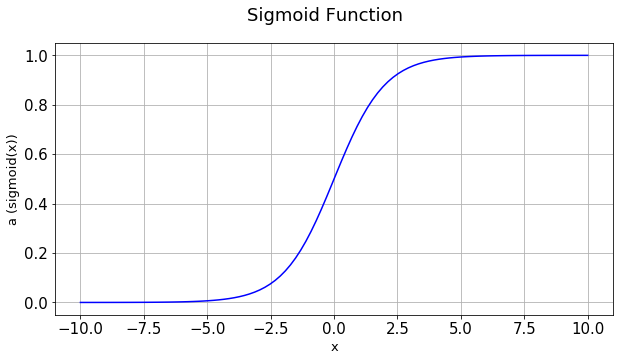

In [114]:
x=np.linspace(-10,10,100)         #linspace generates 100 uniformly spaced values between -10 and 10
plt.figure(figsize=(10, 5))       #Setting up the figure size of width 10 and height 5
plt.plot(x,sigmoid(x),'b')        #Plot sigmoid(x) in Y-axis and x in X-axis with line color blue
plt.grid()                        #Add grid to the plot 
plt.rc('axes', labelsize=13)      #Set x label abd y label fontsize to 13
plt.xlabel('x')                   #Label x-axis 
plt.ylabel('a (sigmoid(x))')      #Label y axis
plt.rc('font', size=15)           #Set text fontsize default as 15
plt.suptitle('Sigmoid Function')  #Create a supertitle for the plot. You can use title as well

As you can see from the graph, a(sigmoid(x)) varies between 0 and 1. This makes sigmoid function and in turn logistic regression suitable for binomial classification problem. That means we can use logistic regression or sigmoid function when the target varible has only two values(0 or 1). This makes it suitable for our purpose, in which we are trying to predict the gender of the celebrity from images. Gender(our target variable) has only two values in our dataset, male(0) and female(1). 

Sigmoid function essentially gives out the probabilty target variable being 1 for a given input. i.e in our case given an image, sigmoid function gives the probability of that image being that of a female celebrity, since in our target variable female gender is indicated as 1. Although, probabilty of an image being male can be easily calculated as 1-sigmoid(input image) will give that.

Another point to remember is that, for our problem input x is a combination of variables or pixels to be precise. Let's denote this combination of input variables as z. 

\begin{equation*}
z=w1*x1 + w2*x2 +...+w_n*x_n + b
\end{equation*}

where, <br>
w1 = weight of the first variable (in our case the first pixel) <br>
x1 = first variable (in our case, first pixel) and so on.. <br>
b = bias (similar to intercept in linear regression)

\begin{equation*}
a=\sigma(z) 
\end{equation*}
<br>
where 
$\sigma $ is the sigmoid function <br>
and a is the predicted values(probabilities)

<br>
In matrix notation, the equations can be written as, <br>

\begin{equation*}
Z=W.X +b \\
A=\sigma(Z) 
\end{equation*}
<br>

where '.' indicates matrix multiplication <br>
W is the row vector of all weights of dimension[1,num_px] num_px is the number of pixels(variables) <br>
X is the input matrix of dimension[num_px,m] m = no.of training examples <br>
A is the array of predicted values of dimension[1,m]



<a name="Cost Function "></a>
## Cost Function

The unknowns in the above equations are weights(w's) and bias(b). The idea of logistic regression or single neuron neural network(from now on I will use this terminology) is to find the best values of weights and bias in order which gives the minimum error(cost).

So for training the model first we have to define the cost function. We define the cost function for the binomial prediction as 

\begin{equation*}
J(a,y)= -{\frac{1} {m}} \sum_{i=1}^m ylog(a) + (1-y)log(1-a)
\end{equation*}

where,<br>
J(a,y) is the cost which is a function of a and y and it is a scalar meaning single value. This cost is called negative log likelihood. Lower the cost, better the model<br>
m = number of training examples<br>
y = array of true labels or actual values  <br>
a = $\sigma(z)$ , the predicted values <br>
z = w1*x1 + w2*x2 +...+w_n*x_n + b
<br>

In matrix form we write it as,

\begin{equation*}
J(A,Y)= -{\frac{1} {m}} *( Ylog(A^T) + (1-Y)log((1-A)^T))
\end{equation*}

where, <br>
m is the number of training examples <br>
$A^T$ is the transpose of A which is the array of predicted values of dimensions [m,1] <br>
Y is the array actual values or true labels of dimensions [1,m]

<a name="Training a single neuron steps "></a>
## Steps to train a single neuron

Now we have to use gradient descent to find the values of W and b that minimizes the cost. For an intuitive and detailed explanation of gradient descent, you can check the [post](https://wp.me/p9ttN2-P) which I mentioned earlier.

In short, training of single neuron neural network using gradient descent involves the following steps:<br>
<br>
1) Initialize parameters i.e W and b<br><br>
2) **Forward Propagation**: Calculate Z and A using the initialized parameters<br><br>
3) Compute cost <br><br>
4) **Backward propagation**: Take gradient(derivative) of cost function with respect to W and b<br><br>
5) Use the gradients to update the values of W and b<br><br>
6) Repeat steps 2 to 5 for a fixed number of times<br><br>

<a name="Forward Propagation "></a>
### Forward Propagation

In steps 2 and 3, we calculate the values of A and Z as mentioned before and comput the cost. This step is called **forward propagation**
<img src="images/part2/Forward_propagation.png" style="width:1104;height:286;">

<a name="Backward Propagation "></a>
### Backward Propagation

In steps 4 and 5, we have to take the derivative of cost function w.r.t W(each of the weights) and b. This step is called **backward propagation**. We will have to use chain rule in calculus for calculating this. <br>
<br> 
\begin{equation*}
{\frac{\mathrm{d}J}{\mathrm{d}w}} = {\frac{\mathrm{d}J}{\mathrm{d}a}}.{\frac{\mathrm{d}a}{\mathrm{d}z}}.{\frac{\mathrm{d}z}{\mathrm{d}w_i}}
\end{equation*}

Similiarly,
\begin{equation*}
{\frac{\mathrm{d}J}{\mathrm{d}b}} = {\frac{\mathrm{d}J}{\mathrm{d}a}}.{\frac{\mathrm{d}a}{\mathrm{d}z}}.{\frac{\mathrm{d}z}{\mathrm{d}b}}
\end{equation*}

In Matrix form we can write it as,
\begin{equation*}
{\frac{\mathrm{d}J}{\mathrm{d}W}} = {\frac{\mathrm{d}J}{\mathrm{d}A}}.{\frac{\mathrm{d}A}{\mathrm{d}Z}}.{\frac{\mathrm{d}z}{\mathrm{d}W}} = {\frac{\mathrm{d}J}{\mathrm{d}Z}}.{\frac{\mathrm{d}Z}{\mathrm{d}W}}
\end{equation*}

and,
\begin{equation*}
{\frac{\mathrm{d}J}{\mathrm{d}b}} = {\frac{\mathrm{d}J}{\mathrm{d}A}}.{\frac{\mathrm{d}A}{\mathrm{d}Z}}.{\frac{\mathrm{d}Z}{\mathrm{d}b}} = {\frac{\mathrm{d}J}{\mathrm{d}Z}}.{\frac{\mathrm{d}Z}{\mathrm{d}b}}
\end{equation*}
<br>
A note on notations that will be used in this articel.
dZ denotes ${\frac{\mathrm{d}J}{\mathrm{d}Z}}$ , dW denotes ${\frac{\mathrm{d}J}{\mathrm{d}W}}$ , db denotes ${\frac{\mathrm{d}J}{\mathrm{d}b}}$ <br>


dZ = ${\frac{\mathrm{d}J}{\mathrm{d}Z}}$ = A-Y <br><br>
dW = ${\frac{\mathrm{d}J}{\mathrm{d}W}}$ = ${\frac{1}{m}}*(dZ.X^T)$ <br><br>
db  = ${\frac{\mathrm{d}J}{\mathrm{d}b}}$ = $mean(dZ)$<br><br>

where $X^T $ is the transpose of X.
<br><br><br><br><br>

<img src="images/part2/Backward_propagation.png" style="width:1104;height:286;">

<br><br>
In the above diagram, backward propagation is highlighted by red colored line. From the point of view of logical flow of the network, backward propagation starts from the cost and reaches W. The intuition is we need to update the parameters(W and b) of the model to minimze cost, and in order to do that we need to find the derivative of cost w.r.t the parameters we want to update. However, cost is not directly dependent on parameter(W and b) but on functions(A and Z) which uses these parameters. Hence we need to use chain rule to calculate the derivative of cost w.r.t to parameters. Each derivative term in the chain rule happens at a different part in the model, which starts at cost and flows backward. 
<br><br>
For detailed explanation and derivations you can refer this [post](https://wp.me/p9ttN2-2M).

<a name="Parameter Updates "></a>
### Parameter Updates
In step 5, we need to update the parameters as follows <br><br>
$W=W- \alpha .dW$<br><br>
$b=b- \alpha .db$<br><br>
Here $\alpha$ is a parameter called learning rate. It controls how big the update(or step) is in each iteration. If $\alpha$ is too small, it may take a long time to find the best parameters and if $\alpha$ is too big we may overshoot and never reach the optimal parameters.

<img src="images/part2/small_large_alpha.png" style="width:1104;height:286;">

In step 6, we need to repeat the steps a fixed number of times. There is no rule as such how many iterations we have to run. It varies from dataset to dataset. If we set alpha to a very small value, we may need to iterate more number of times. Generally it's a hyperparameter which we have to tune.
<br><br>
That's all we need to know to implement a single neuron neural network.<br><br>
So to reiterate the steps involved: <br><br>
1) Initialize parameters i.e W and b<br><br>
2) **Forward Propagation**: Calculate Z and A using the initialized parameters<br><br>
3) Compute cost <br><br>
4) **Backward propagation**: Take gradient(derivative) of cost function with respect to W and b<br><br>
5) Use the gradients to update the values of W and b<br><br>
6) Repeat steps 2 to 5 for a fixed number of times<br><br>

<a name="Single neuron implementation "></a>
## Single Neuron Implementation

I will continue from where I stopped in the last [article](https://wp.me/p9ttN2-2m). I will continue with the same problem and same dataset. <br><br><br>
Our problem statement was to predict the gender of the celebrity from the image.<br><br>
After preprocessing, our final datasets were train_x(train data input) , y_train(target variable for the training set), test_x(test data input) , y_test(target variable for the testing set) 


Loading the necessary libraries

In [124]:
import os
import numpy as np
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline

Let's take a quick look at the data attributes.

In [128]:

m_train = train_x.shape[1]
m_test = y_test.shape[1]
num_px = train_x_orig.shape[1]


print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x shape: " + str(train_x.shape))
print ("y_train shape: " + str(y_train.shape))
print ("test_x shape: " + str(test_x.shape))
print ("y_test shape: " + str(y_test.shape))

Number of training examples: m_train = 80
Number of testing examples: m_test = 20
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_x shape: (12288, 80)
y_train shape: (1, 80)
test_x shape: (12288, 20)
y_test shape: (1, 20)


** Step 1) Initialize parameters i.e W and b ** <br><br>
Let's write a function to initialize W and b. There are different intialization techniques. For this exercise, we will intialize both W and b to zero.<br><br>

In [131]:
def initialize_with_zeros(dim):
    #Function takes in a parameter dim whic is equal to no of columns or pixels in the dataset
    w = np.zeros((1,dim))
    b = 0
    assert(w.shape == (1, dim)) #Assert statement ensures W and b has the required shape
    assert(isinstance(b, float) or isinstance(b, int))
    return w, b

** Steps 2, 3 and 4 Forward Propagation, Cost computation and Backward propagation ** <br><br>
We will define a sigmoid function first, which will take any array or vector as an input and returns the sigmoid of the input.

In [130]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))   
    return s

Now let's write a function called propagate, which will take W(weights),b(bias),X(input matrix) and Y(target variable) as inputs. It should return cost and gradients dW and db. <br> 
We need to calculate the following: <br><br>
A= $\sigma(Z)$= $\sigma(W.X +b)$ <br><br>
Cost = $ -{\frac{1} {m}} *( Y.log(A^T) + (1-Y).log((1-A)^T))$ <br><br>

dW = ${\frac{1}{m}}*(dZ.X^T)$  = ${\frac{1}{m}}*((A-Y).X^T)$ <br><br>
db  = $mean(dZ)$ = $mean(A-Y)$<br><br>

where '.' indicates matrix multiplication. In python, np.dot(numpy.dot) function is used for matrix multiplication.<br>

In [129]:
def propagate(w, b, X, Y):
    """
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if male celebrity, 1 if female celebrity) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w,X)+b)                                    # compute sigmoid- np.dot is used for matrix multiplication
    cost = (-1/m)*(np.dot(Y,np.log(A.T))+ np.dot((1-Y),np.log((1-A).T)))                                 # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1/m)*np.dot((A-Y),X.T)
    db = (1/m)*np.sum((A-Y))

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)                                      #to make cost a scalar i.e a single value
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

** Steps 5 and 6 Optimization:Update parameters and iterate ** <br><br>
Let's define a function optimize which will repeat steps 2 through 5 for a given number of times.<br><br> Steps 2 till 4 can be calculated by calling the propagate function. We need to define step 5 here. i.e parameter updates. Update rules are: <br><br>
$W=W- \alpha .dW$<br><br>
$b=b- \alpha .db$<br><br>
were $\alpha$ is the learning rate. <br> <br>
After iterating through the given number of iterations, this function should return the final weights and bias

In [162]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if male celebrity, 1 if female celebrity) of size (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    """
    
    costs = []
    
    for i in range(num_iterations):           #This will iterate i from 0 till num_iterations-1
        
        
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule 
        w = w-learning_rate*dw
        b = b-learning_rate*db
        
        # Record the costs for every 100th iteration
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
        # plot the cost
    plt.rcParams['figure.figsize'] = (10.0, 10.0)    
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

** Prediction using learned parameters**<br> <br>
From the previous function we will get the final weights and bias. We can use those weights to predict the target variable(gender) on new data(test data). Let's define a function for prediction capability. If the predicted probability is 0.5 or less, the image will be calssified as 0(male) else 1(female).

In [136]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    #w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of having a female celebrity in the picture
    A = sigmoid(np.dot(w,X)+b)   
    Y_prediction=np.round(A)

    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

** Putting everything together** <br><br>
Let's put training and prediction into a sigle function called model, which will train the model on training data and predict on testing data and return accuracy of the model. Since we have to predict 0 or 1, we can calculate accuray using the formula:<br><br>
$ Accuracy = 100*(1 - mean(A-Y))$ <br><br>
It indicates what percentage of images have been rightly classified or predicted.<br>
You can define any accuracy or evaluation metrics. However, in this series we will use accuracy defined as above.


In [139]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros
    m_train=X_train.shape[0]
    w, b = initialize_with_zeros(m_train)

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations= num_iterations, learning_rate = learning_rate, print_cost = print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100*(1 - np.mean(np.abs(Y_prediction_train - Y_train)) )))
    print("test accuracy: {} %".format(100*(1 - np.mean(np.abs(Y_prediction_test - Y_test)) )))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.325803
Cost after iteration 200: 0.209219
Cost after iteration 300: 0.159637
Cost after iteration 400: 0.128275
Cost after iteration 500: 0.106781
Cost after iteration 600: 0.091209
Cost after iteration 700: 0.079450
Cost after iteration 800: 0.070282
Cost after iteration 900: 0.062948


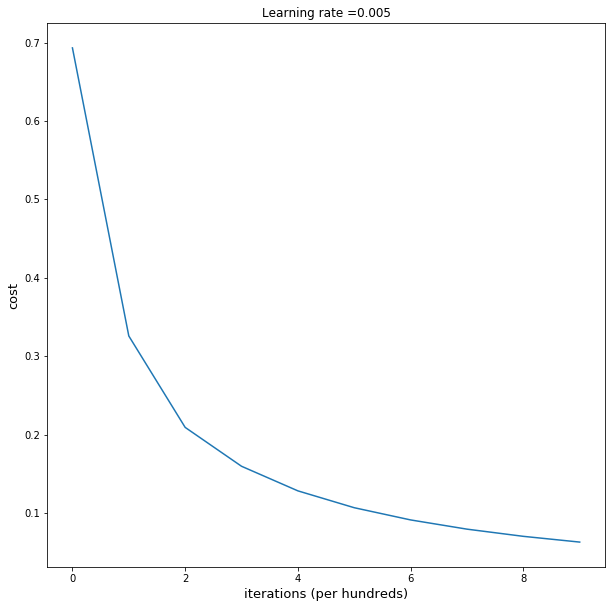

train accuracy: 100.0 %
test accuracy: 65.0 %


In [167]:
d = model(train_x, y_train, test_x, y_test, num_iterations = 1000, learning_rate = 0.005, print_cost = True)

The accuracy of the model is around 65% with learning rate =0.005 and number of iterations =1000. Probably we can achieve bit more better results by tuning these two parameters. <br><br>
Now, let's take a look at the mis labeled or wrongly predicted images.

In [255]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='sinc')
        plt.axis('off')
        plt.rc('font', size=20)
        plt.title("Prediction: " + classes[int(p[0,index])] + " \n Class: " + classes[y[0,index]])

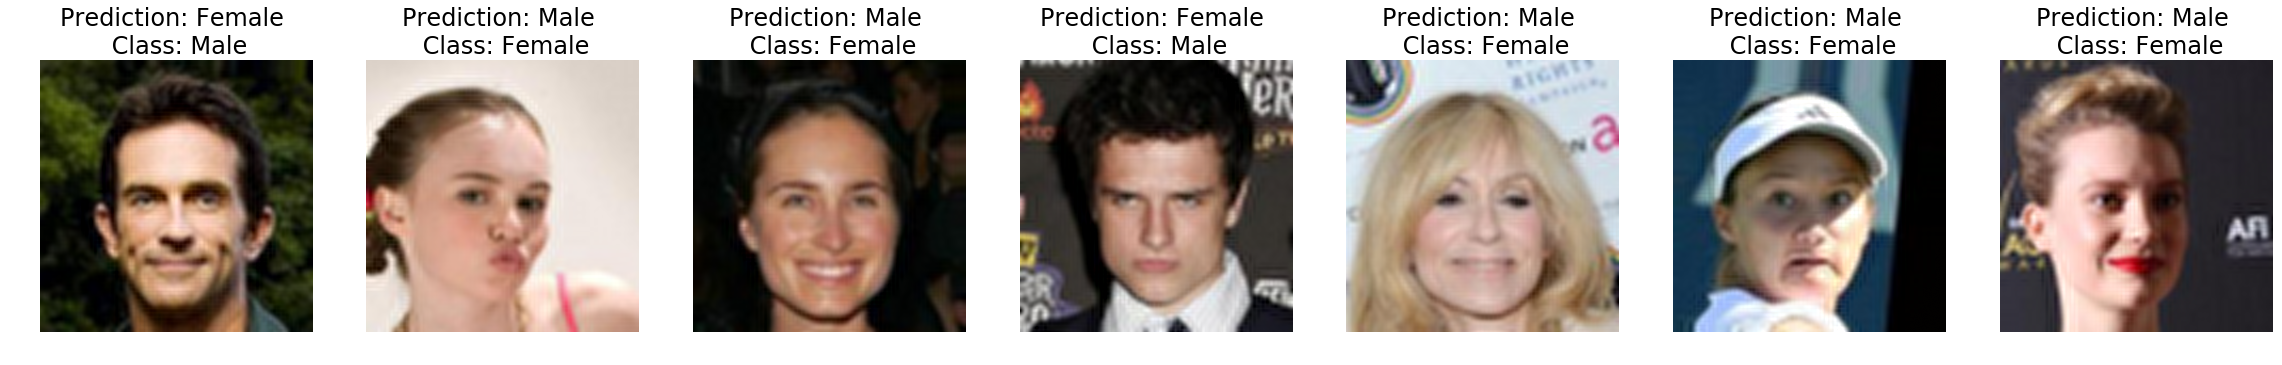

In [256]:
print_mislabeled_images(classes, test_x, y_test, d["Y_prediction_test"])

So now we have completed training a single node neural network. We have achieved an accuracy of 65 %. Not bad for a single neuron or simple logistic regression. It's a bit long post but understanding the basics is the key to understand more complex algorithms. Sigmoid function(or similar functions) is the building block for Neural Networks, Deep learning and AI. I hope this article gave a good intuition about the sigmoid function and neural network approach.<br><br>
Building on top of this article, in the next post, I will talk about how to train a multi layer neural network. <br>

<br><br>Before wrapping up, I will try to show what the neuron has learned at the end of training. Now this part is not for weak hearted people. Continue only if you are brave and curious :D.<br><br>

Let's use the final weights to multiply corresponding pixels in training data and scale by a factor 255, since we divided pixels by 255 for standadrization.<br><br>
Now let's plot an image from the recostructed data.

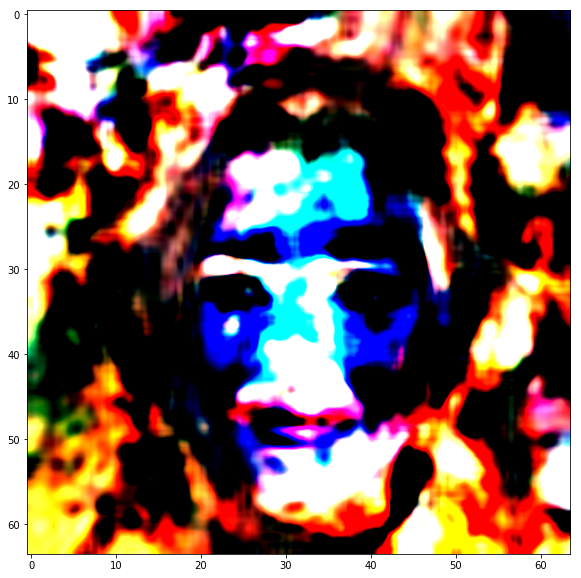

In [237]:
test=d["w"].T*train_x*255
test=test.T.reshape(80,64,64,3)
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(test[0], interpolation='sinc')

You may either find the image artistic or scary or weird. Neverthless it's still very interesting, atleast for me ;). For plotting the above image I used sinc interpolation. We can try different interpolations and see the effects.

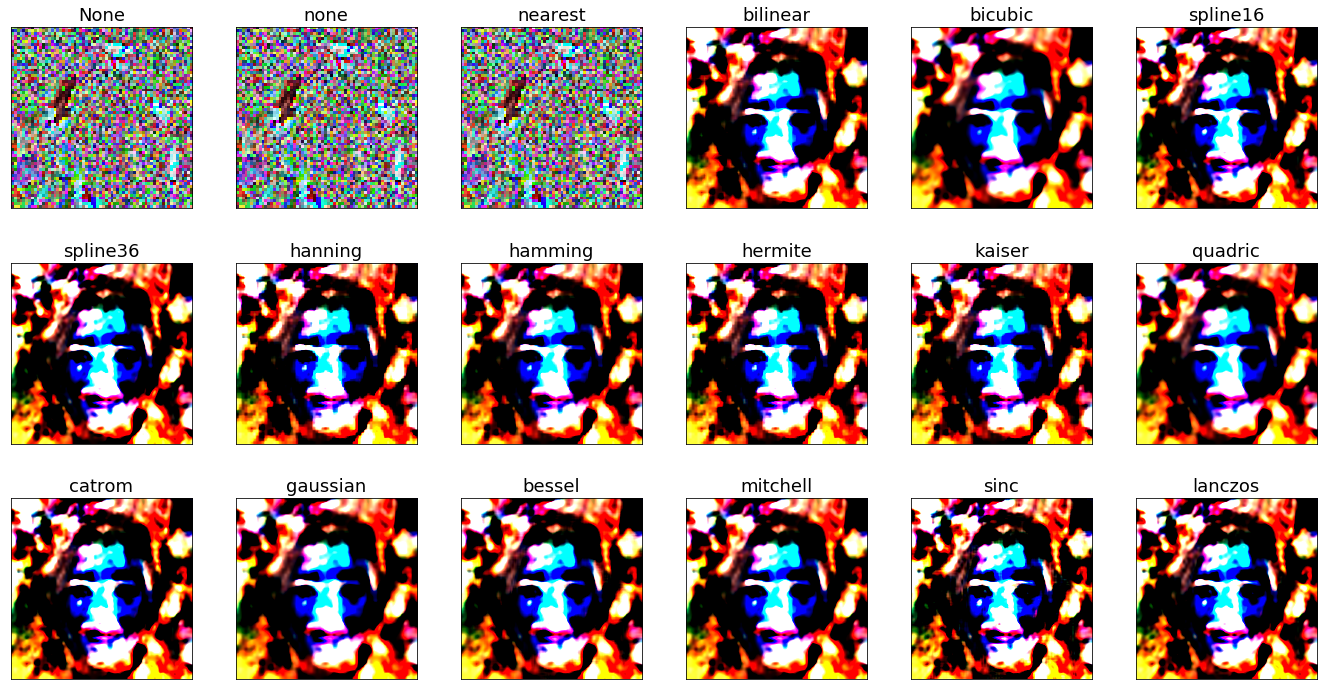

In [259]:
methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']

# Fixing random state for reproducibility
np.random.seed(19680801)


fig, axes = plt.subplots(3, 6, figsize=(24, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

for ax, interp_method in zip(axes.flat, methods):
    plt.rc('font', size=15)
    ax.imshow(test[0], interpolation=interp_method, cmap=None)
    ax.set_title(interp_method)

plt.show()


Let's create a montage and compare the reconstructed images vs original.

In [239]:
def montage(images, saveto='montage.png'):
    """Draw all images as a montage separated by 1 pixel borders.
    Also saves the file to the destination specified by `saveto`.
    Parameters
    ----------
    images : numpy.ndarray
        Input array to create montage of.  Array should be:
        batch x height x width x channels.
    saveto : str
        Location to save the resulting montage image.
    Returns
    -------
    m : numpy.ndarray
        Montage image.
    """
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    if len(images.shape) == 4 and images.shape[3] == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5
    else:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    #plt.imsave(arr=m, fname=saveto)
    return m

The above function can be used to create montages. Now let's combine some of the reconstructed images and original data and create a montage. 

In [240]:
compare = np.concatenate((test[52:54], data[52:54]), axis=0)
compare.shape

(4, 64, 64, 3)

Now let us try to create the montage with two different interpolations.

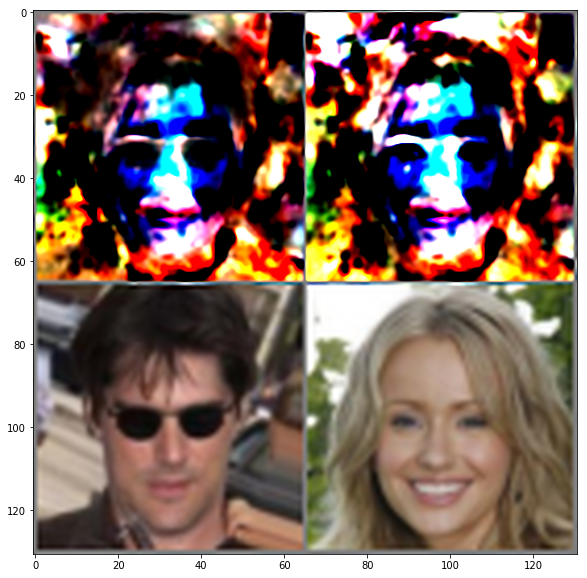

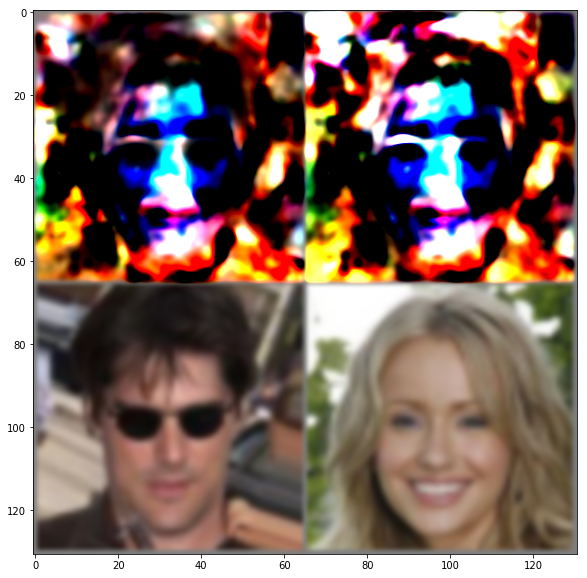

In [241]:
plt.imshow(montage(compare,saveto='montage.png'),interpolation='spline36')
plt.show()
plt.imshow(montage(compare,saveto='montage.png'),interpolation='bicubic')
plt.show()

If you look carefully, in the reconstructed image, hair colors of the image have been captured differently. This is an indication that the algorithm has learned some of the facial features from the data. <br><br>
Also, other thing we can do is to generate the montage with different interpolations for comparison.

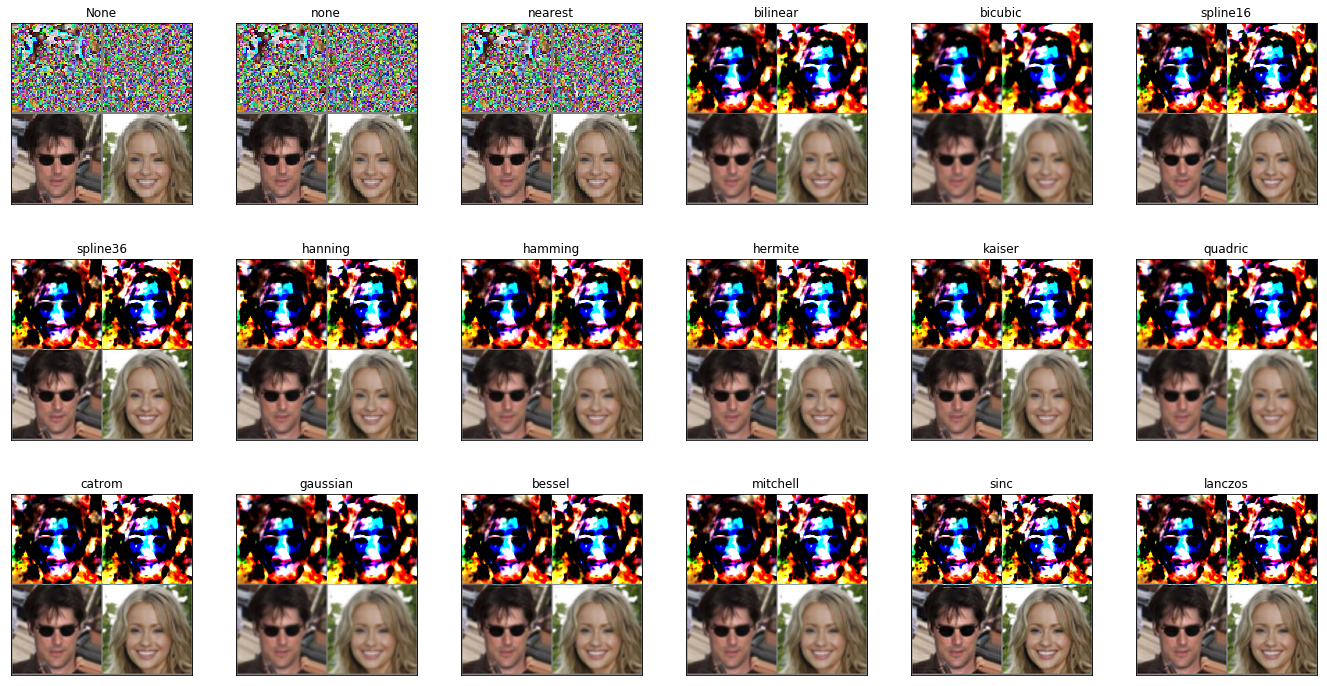

In [232]:
methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']

# Fixing random state for reproducibility
np.random.seed(19680801)


fig, axes = plt.subplots(3, 6, figsize=(24, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

for ax, interp_method in zip(axes.flat, methods):
    ax.imshow(montage(compare,saveto='montage.png'), interpolation=interp_method, cmap=None)
    ax.set_title(interp_method)

plt.show()

Images are very interesting. We can find very interesting patterns and visulaize how an algorithm learns to identify patterns in the image. It always amazes me. On that note I am putting my pen down on this article. In the next article, I will talk about multi layer neural networks and try to explore what the neurons have learned from the images<br> <br>

- [Jobil Louis Joseph](https://www.linkedin.com/in/jobillouisjoseph/)

<br> <br> References: <br>
'Neural Networks and Deep Learning' on Coursera by Andrew Ng<br>
Calculus by Gilbert Strang